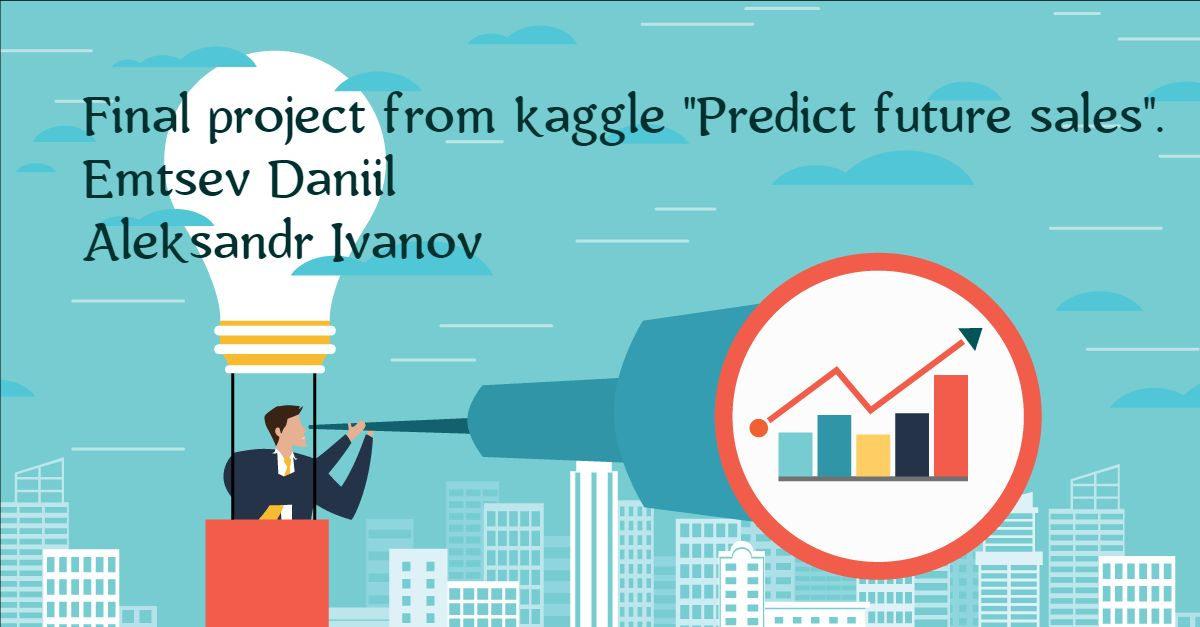

## Our target: predict total sales for every product and store in the next month.

In [1]:
import numpy as np
import pandas as pd
from sklearn import metrics
import nltk, datetime

import xgboost as xgb

import seaborn as sns

import gc
import time 

from functions import *

# Read data

In [26]:
train = pd.read_csv('sales_train.csv')

test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
items = pd.read_csv('items.csv')
item_cats = pd.read_csv('item_categories.csv')
shops = pd.read_csv('shops.csv')

train = train[(train.shop_id.isin(test.shop_id.unique())) & 
                                (train.item_id.isin(test.item_id.unique()))]

shops = shops[shops.shop_id.isin(test.shop_id.unique())]

print('train:', train.shape, 'test:', test.shape)

train_bak = train.copy()

train: (1224439, 6) test: (214200, 3)


In [31]:
print(train.head())
print(items.head())

         date  date_block_num  shop_id  item_id  item_price  item_cnt_day
0  02.01.2013               0       59    22154       999.0           1.0
1  03.01.2013               0       25     2574       399.0           2.0
2  05.01.2013               0       25     2574       399.0           1.0
3  07.01.2013               0       25     2574       399.0           1.0
4  08.01.2013               0       25     2574       399.0           2.0
                                           item_name  item_id  \
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0   
1  !ABBYY FineReader 12 Professional Edition Full...        1   
2      ***В ЛУЧАХ СЛАВЫ   (UNV)                    D        2   
3    ***ГОЛУБАЯ ВОЛНА  (Univ)                      D        3   
4        ***КОРОБКА (СТЕКЛО)                       D        4   

   item_category_id  
0                40  
1                76  
2                40  
3                40  
4                40  


In [27]:
print('Before drop train shape:', train.shape)
train.drop_duplicates(subset=['date', 'date_block_num', 'shop_id', 'item_id', 'item_cnt_day'], 
                      keep='first', inplace=True)
train.reset_index(drop=True, inplace=True)
print('After drop train shape:', train.shape)
(train.item_id < 0).sum()

Before drop train shape: (1224439, 6)
After drop train shape: (1224429, 6)


0

In [34]:
print('training set: ', train.shape)
print('test set: ', test.shape)
print('num of shops: ', shops.shape)
print('num of items: ',items.shape)

training set:  (1224429, 6)
test set:  (214200, 3)
num of shops:  (42, 2)
num of items:  (22170, 3)


# Visualising

In [ ]:
data = data.sort_values(by=['date_block_num', 'shop_id', 'item_category_id', 'item_id'])
data = data.reset_index(drop=True)

In [ ]:
data['revenue'] = data['item_cnt_day'] * data['item_price']
data['yymm'] = data['date'].apply(lambda x: x.strftime('%y%m'))
data['shop_item'] = data['shop_id'].map(str) + '_'+ data['item_id'].map(str)

In [ ]:
plotdata = data.groupby('yymm')['revenue'].sum()
plotdata = pd.DataFrame(plotdata)
plotdata.reset_index(level=0, inplace=True)
sns.barplot(x="yymm", y="revenue", data= plotdata)

1. Revenue
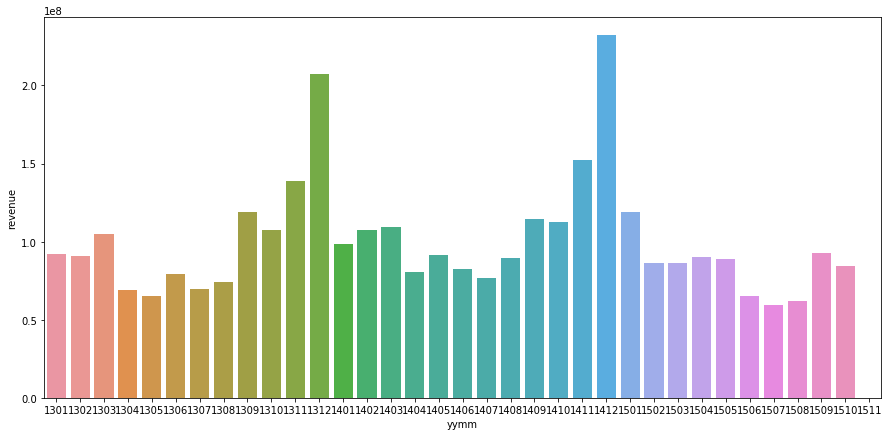

In [ ]:
sns.barplot(x='month', y='revenue', hue='year', data=plotdata)

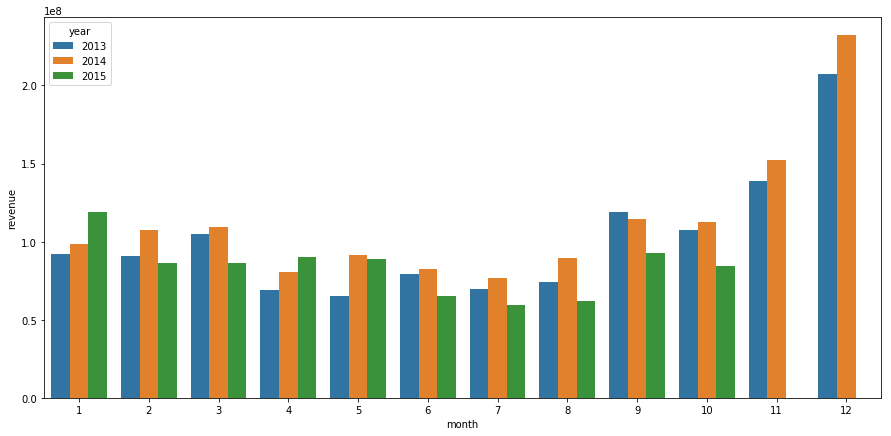

In [ ]:
sns.tsplot(plotdata, time='month', unit='year', condition='year', value='revenue')

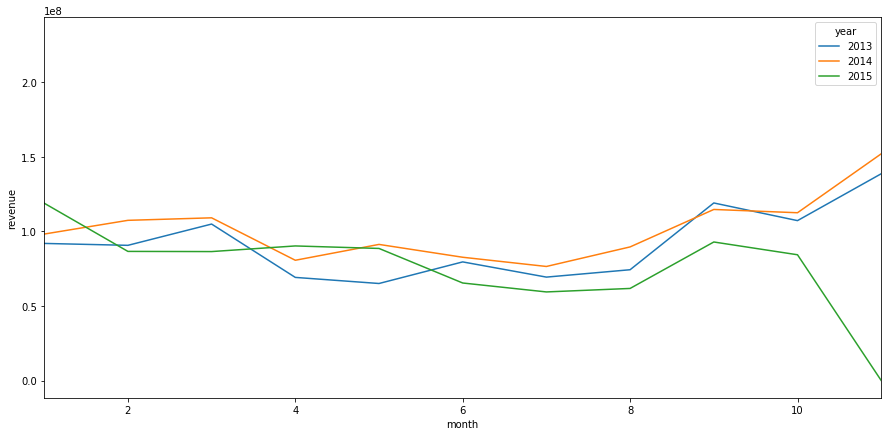

In [ ]:
plotdata = data.groupby(['weekday'])['revenue'].sum()
plotdata = pd.DataFrame(plotdata)
plotdata.reset_index(inplace=True)
sns.barplot(x='weekday', y='revenue', data=plotdata)
#  Monday=0, Sunday=6

Does sales vary by days of week? 
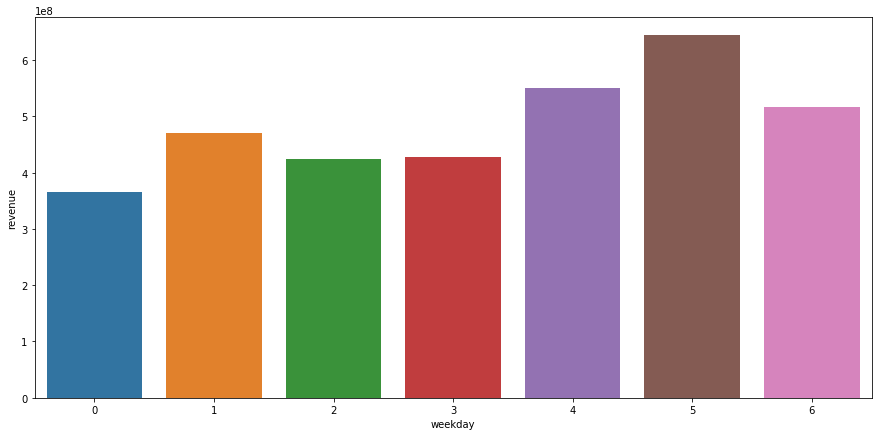

In [ ]:
plot = sns.barplot(x='shop_id', y='revenue', data=plotdata)

How much revenue does each shop_id generate?
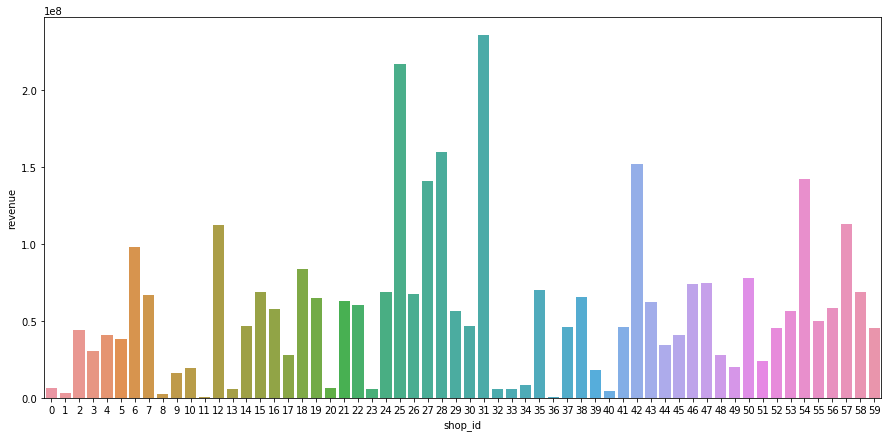

In [ ]:
sales_train_shops = pd.DataFrame(df_sales_train.groupby(['shop_id', 'date_block_num'])['item_cnt_day'].sum().reset_index())

sales_train_shops = sales_train_shops.set_index('shop_id').join(df_shops.set_index('shop_id')).reset_index()

fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(20, 25))
num_graph = 10
id_per_graph = math.ceil(sales_train_shops.shop_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='date_block_num', y='item_cnt_day', hue='shop_name', data=sales_train_shops[
                np.logical_and(count*id_per_graph <= sales_train_shops['shop_id'], 
                               sales_train_shops['shop_id'] < (count+1)*id_per_graph)], 
                ax=axes[i][j])
        axes[i][j].grid()
        count += 1

Total sales and availability of information on them in the required stores

Picks in the same place(December-hot month)
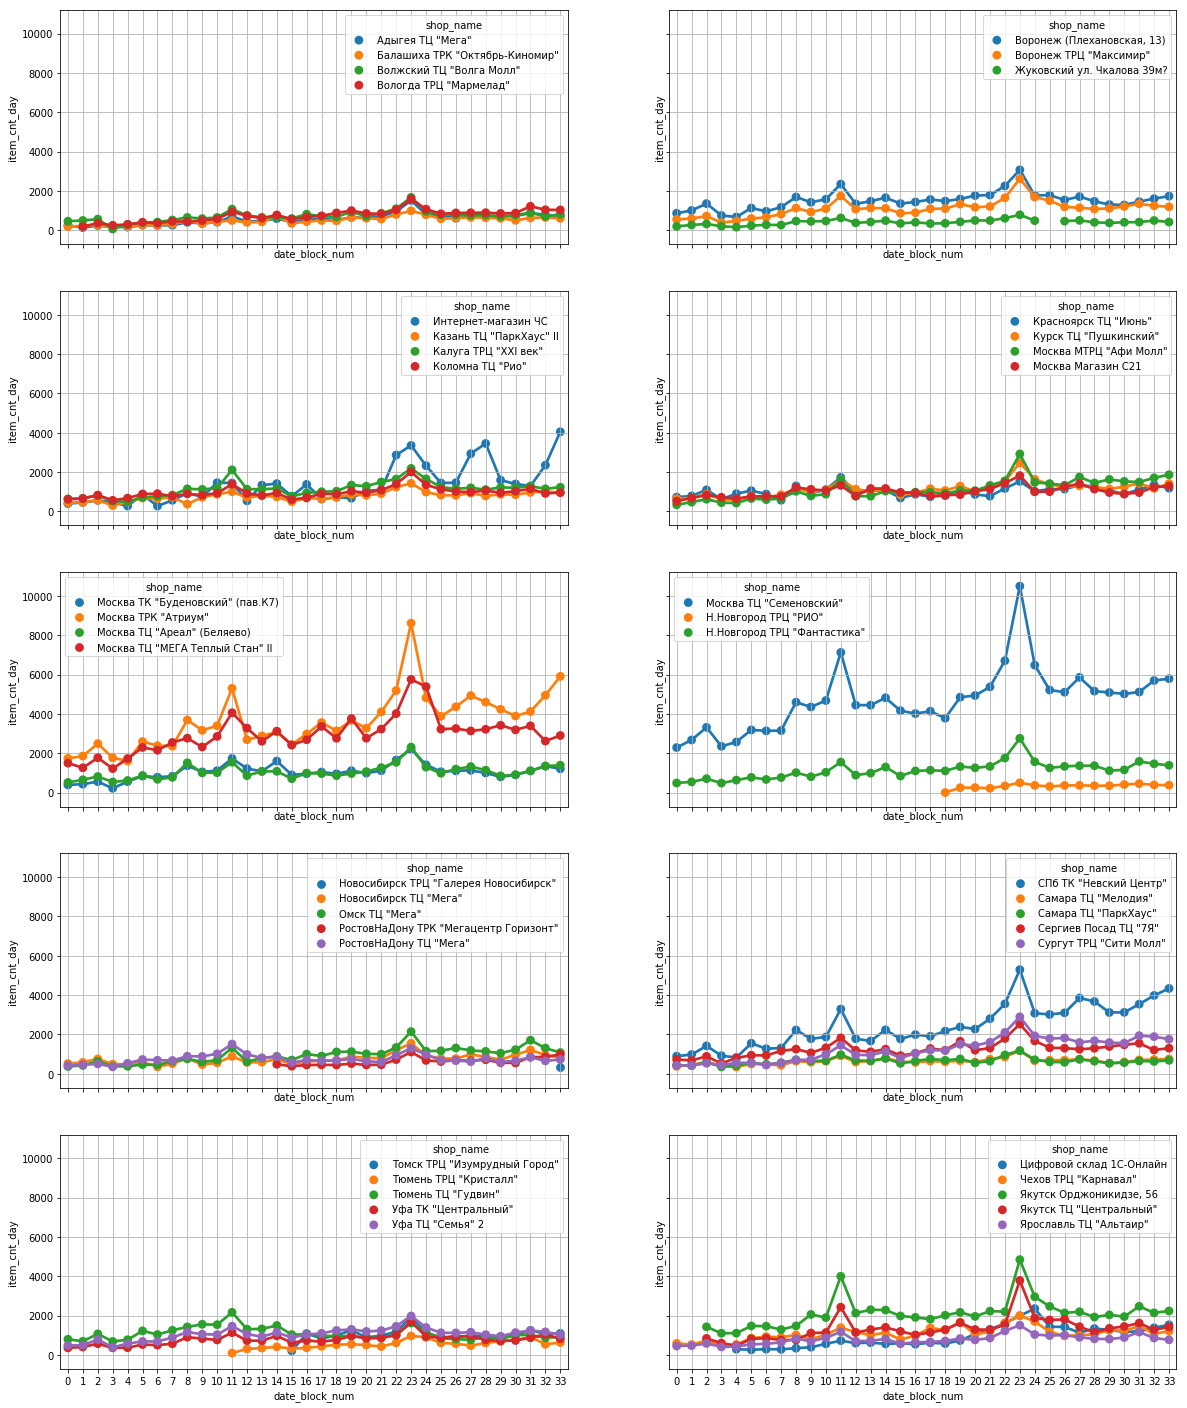

Let's see what is there with sales by product category

In [ ]:
sales_train_categories = df_sales_train.set_index('item_id') \
                    .join(df_items.set_index('item_id')).drop('item_name', axis=1) \
                    .reset_index()


sales_train_categories = sales_train_categories.set_index('item_category_id') \
                    .join(df_item_categories.set_index('item_category_id')) \
                    .reset_index() \
    
sales_train_categories['month'] = sales_train_categories.date.apply(
                                        lambda x: datetime.datetime.strptime(x, '%d.%m.%Y').strftime('%m')
                    )
sales_train_categories['year'] = sales_train_categories.date.apply(
                                        lambda x: datetime.datetime.strptime(x, '%d.%m.%Y').strftime('%Y')
                    )

fig, axes = plt.subplots(nrows=5, ncols=2, sharex=True, sharey=True, figsize=(20,25))
num_graph = 10
id_per_graph = math.ceil(sales_train_categories.item_category_id.max() / num_graph)
count = 0
for i in range(5):
    for j in range(2):
        sns.pointplot(x='month', y='item_cnt_day', hue='item_category_name', 
                      data=sales_train_categories[
                                      np.logical_and(
                                                  count*id_per_graph <= sales_train_categories['item_category_id'], 
                                                  sales_train_categories['item_category_id'] < (count+1)*id_per_graph
                                                    )
                                                  ], 
                      ax=axes[i][j])
        axes[i][j].grid()
        count += 1

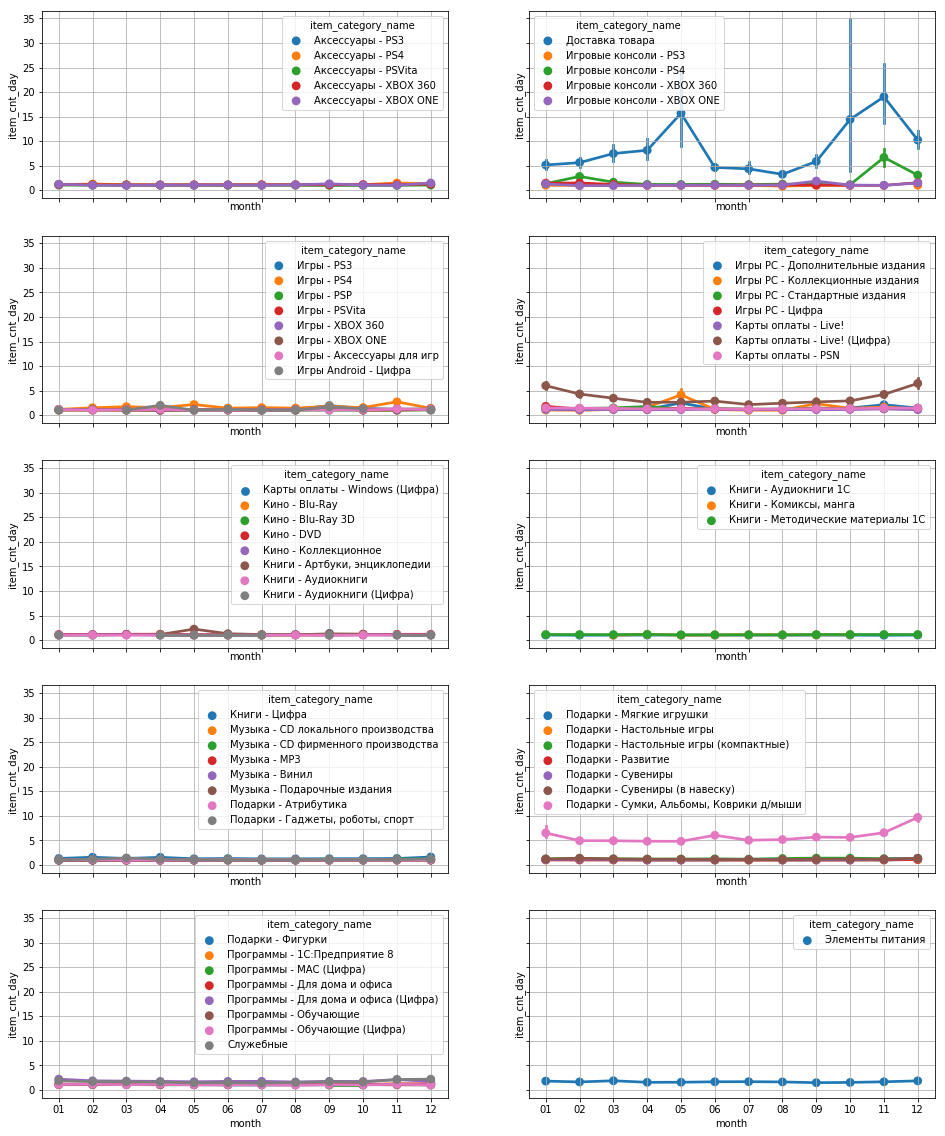

In [ ]:
ts=sales.groupby(["date_block_num"])["item_cnt_day"].sum()
ts.astype('float')
plt.figure(figsize=(16,8))
plt.title('Total Sales of the company')
plt.xlabel('Time')
plt.ylabel('Sales')
plt.plot(ts);

seasonality
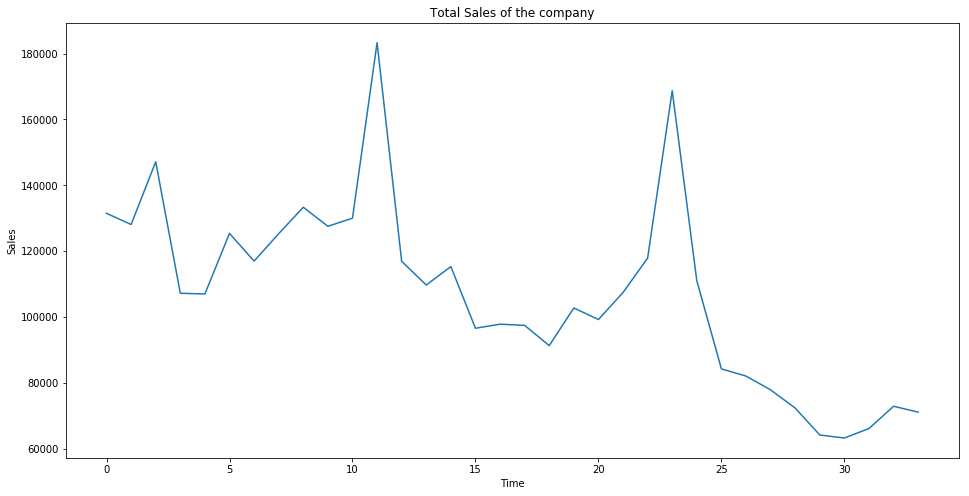

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(),label='Rolling Mean');
plt.plot(ts.rolling(window=12,center=False).std(),label='Rolling sd');
plt.legend();

decreasing "Trend"
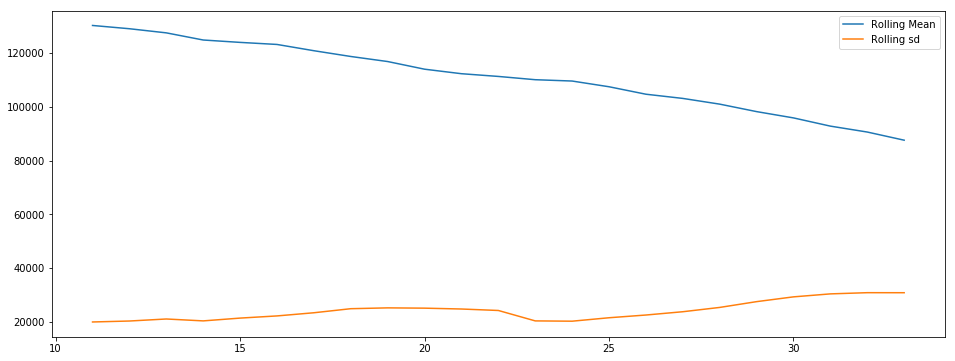

# Shops features

In [21]:
# SHOPS features

categories_mean_prices = pd.merge( pd.merge(train, items, how='left', on=['item_id']), item_cats, how='left', on=['item_category_id'] )\
        .groupby(['item_category_id', 'shop_id'])

tmp = categories_mean_prices['item_price'].mean().reset_index()
tmp = pd.merge(tmp, tmp.groupby('item_category_id')[['item_price']].mean(), how='left', on=['item_category_id'])
tmp['relative_categoty_price'] = tmp['item_price_x'] / tmp['item_price_y'] - 1
tmp.drop(['item_price_x', 'item_price_y'], axis=1, inplace=True)

categories_mean_prices = tmp
tmp = None

categories_mean_prices.groupby('shop_id', as_index=False)[['relative_categoty_price']].mean()

shops = pd.merge(shops, categories_mean_prices.groupby('shop_id', as_index=False)[['relative_categoty_price']].mean(), \
                how='left', on=['shop_id']).fillna(0.0)


# shops month mean revenue
tmp = train.copy()
tmp['revenue'] = tmp['item_cnt_day'] * tmp['item_price']

tmp = tmp.groupby(['shop_id'])[['revenue']].sum().reset_index()
tmp['revenue'] = np.log1p(tmp['revenue'])
tmp.revenue = tmp.revenue / tmp.revenue.mean()

shops = pd.merge(shops, tmp, how='left', on=['shop_id']).fillna(0.0)

shops.drop('shop_name', axis=1, inplace=True)
tmp = None
gc.collect()
shops.head()

,shop_id,relative_categoty_price,revenue
0,2,0.038918,0.995864
1,3,0.000310,0.973460
2,4,-0.017129,0.984622
3,5,-0.021043,0.985785
4,6,0.010719,1.035833


# Train transformation

In [22]:
train['date'] = pd.to_datetime(train['date'], format='%d.%m.%Y')
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year


train = train.drop(['date', 'item_price'], axis=1)
train = train.groupby([c for c in train.columns if c not in ['item_cnt_day', 'cost']], as_index=False)[['item_cnt_day']].sum()
train = train.rename(columns={'item_cnt_day':'item_cnt_month'})

#train = pd.merge(train, cost, how='left', on=[c for c in train.columns if c not in ['item_cnt_day', 'cost']])

train.head()

,date_block_num,shop_id,item_id,month,year,item_cnt_month
0,0,2,33,1,2013,1.0
1,0,2,482,1,2013,1.0
2,0,2,491,1,2013,1.0
3,0,2,839,1,2013,1.0
4,0,2,1007,1,2013,3.0


# Item price features

In [23]:
# Относительные ценовые свойства

# Средняя цена товара за месяц в каждом магазине
price_mean_shops = train_bak[['item_price', 'item_id', 'shop_id', 'date_block_num']]\
                    .groupby(['item_id', 'shop_id', 'date_block_num'])\
                    .mean().reset_index()
      
    
price_mean_global_month = price_mean_shops.groupby(['item_id', 'date_block_num'])\
                    .agg({'item_price' : [np.min, np.max, np.median, np.mean]})

price_mean_global_month.columns = ["_".join(x).replace('price', 'price_month') for x in price_mean_global_month.columns.ravel()]
price_mean_global_month.reset_index(inplace=True)



price_mean_global_alltime = price_mean_shops.groupby(['item_id'])\
                    .agg({'item_price' : [np.min, np.max, np.median, np.mean]})

price_mean_global_alltime.columns = ["_".join(x).replace('price', 'price_alltime') for x in price_mean_global_alltime.columns.ravel()]
price_mean_global_alltime.reset_index(inplace=True)


price_mean_shops = pd.merge(price_mean_shops, price_mean_global_month, how='left', on=['item_id', 'date_block_num'])
price_mean_shops = pd.merge(price_mean_shops, price_mean_global_alltime, how='left', on=['item_id'])

# отношение цены к средним по этому товару по всем магазинам
price_mean_shops['item_price_month_amin'] /= price_mean_shops['item_price']
price_mean_shops['item_price_month_amax'] /= price_mean_shops['item_price']
price_mean_shops['item_price_month_mean'] /= price_mean_shops['item_price']
price_mean_shops['item_price_month_median'] /= price_mean_shops['item_price']

# отношение цены к средним по ээтому товару за все время
price_mean_shops['item_price_alltime_amin'] /= price_mean_shops['item_price']
price_mean_shops['item_price_alltime_amax'] /= price_mean_shops['item_price']
price_mean_shops['item_price_alltime_mean'] /= price_mean_shops['item_price']
price_mean_shops['item_price_alltime_median'] /= price_mean_shops['item_price']

price_mean_shops.head()

,item_id,shop_id,date_block_num,item_price,item_price_month_amin,item_price_month_amax,item_price_month_median,item_price_month_mean,item_price_alltime_amin,item_price_alltime_amax,item_price_alltime_median,item_price_alltime_mean
0,30,2,2,359.0,0.738162,1.111421,1.111421,1.097150,0.359331,1.111421,0.470752,0.734214
1,30,2,5,399.0,1.000000,1.000000,1.000000,1.000000,0.323308,1.000000,0.423559,0.660609
2,30,2,15,169.0,1.000000,1.000000,1.000000,1.000000,0.763314,2.360947,1.000000,1.559662
3,30,2,16,169.0,1.000000,1.000000,1.000000,1.000000,0.763314,2.360947,1.000000,1.559662
4,30,3,1,399.0,0.664160,1.000000,1.000000,0.985534,0.323308,1.000000,0.423559,0.660609


Our "help" functons: make_lag_features, filter_lag_features, virtual_filter_lag_features, shift_lag_features

In [ ]:
# makes lags
def make_lag_features(dataframe: pd.DataFrame, 
                      time_feature: str, 
                      features_to_lag: list, 
                      features_to_merge: list,
                      lag_indexes: list, 
                      merge_method: str = 'outer',
                      fillna = None):
    
    dataframe_shiftable = dataframe.copy()[features_to_merge + features_to_lag]
    
    features_mask_names = features_to_merge + [current + '_#{}#' for current in features_to_lag]
    
    dataframe = dataframe.drop(features_to_lag, axis=1)
    
    lag_indexes = lag_indexes[:] + [100000]
    
    prev = 0
    for i in tqdm.tqdm(lag_indexes):
            dataframe_shiftable.columns = [ current.format(prev) if (not current in features_to_merge) 
                                           else current for current in features_mask_names ]

            dataframe = pd.merge(dataframe, dataframe_shiftable, how=merge_method, on=features_to_merge)
            
            dataframe_shiftable[time_feature] = dataframe_shiftable[time_feature].apply(lambda x: x + i - prev)
            prev = i
            
    gc.collect()
    if fillna != None:
        dataframe = dataframe.fillna(fillna)
    
    return dataframe


# keeps only selected lags
def filter_lag_features(dataframe: pd.DataFrame,
                        lag_filter: list):

    lag_reg = re.compile('.*_#(\d+)#')
    
    columns_to_drop = []
    for col in dataframe.columns:
        m = lag_reg.match(col)
        if m:
            if not int(m.group(1)) in lag_filter:
                columns_to_drop.append(col)
    
    # print('These columns will be dropped:', columns_to_drop)
    
    if len(columns_to_drop) > 0:
        dataframe = dataframe.drop(columns_to_drop, axis=1)
    
    return dataframe

def virtual_filter_lag_features(dataframe: pd.DataFrame,
                        lag_filter: list):

    lag_reg = re.compile('.*_#(\d+)#')
    
    columns = []
    for col in dataframe.columns:
        m = lag_reg.match(col)
        if m:
            if not int(m.group(1)) in lag_filter:
                pass
            else:
                columns.append(col)
        else:
            columns.append(col)
    
    return columns

# shifts lag column's names
def shift_lag_features(dataframe: pd.DataFrame,
                       lag_shift: int):
    
    reg = re.compile('(.*)_#(\d+)#')
    new_columns = []
    
    for s in dataframe.columns:
        m = reg.match(s)
        if not m:
            new_columns.append(s)
        else:
            new_s = m.group(1) + '_#{}#'.format(int(m.group(2)) + lag_shift)
            new_columns.append(new_s)
    
    dataframe.columns = new_columns
    
    return dataframe
        

# Merge Price features and lag it

In [24]:
train = pd.merge(train, price_mean_shops, how='left', on=['item_id', 'shop_id', 'date_block_num'])

price_mean_global_month = None
price_mean_shops = None
price_mean_global_alltime = None

# lag_size = 12
lag_indexes = [0, 1, 2, 3, 4, 11, 12]
lag_size = max(lag_indexes)

lag_features = ['item_cnt_month', 'item_price', 'item_price_month_amin',\
               'item_price_month_amax', 'item_price_month_median', 'item_price_month_mean',\
               'item_price_alltime_amin', 'item_price_alltime_amax', 'item_price_alltime_median',\
               'item_price_alltime_mean']
features_to_merge = ['shop_id', 'item_id', 'date_block_num']

train = make_lag_features(train, 'date_block_num', lag_features, features_to_merge, lag_indexes, 'outer', 0.0)

train = train[train['date_block_num'] >= lag_size]
gc.collect()

train.head()

100%|██████████| 7/7 [00:09<00:00,  1.37s/it]


,date_block_num,shop_id,item_id,month,year,item_cnt_month_#0#,item_price_#0#,item_price_month_amin_#0#,item_price_month_amax_#0#,item_price_month_median_#0#,...,item_cnt_month_#12#,item_price_#12#,item_price_month_amin_#12#,item_price_month_amax_#12#,item_price_month_median_#12#,item_price_month_mean_#12#,item_price_alltime_amin_#12#,item_price_alltime_amax_#12#,item_price_alltime_median_#12#,item_price_alltime_mean_#12#
124683,12,2,32,1.0,2014.0,1.0,119.0,0.630252,1.252101,1.252101,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
124684,12,2,33,1.0,2014.0,1.0,199.0,1.000000,1.000000,1.000000,...,1.0,499.0,1.000000,1.0,1.0,1.000000,0.266533,1.000000,0.398798,0.484284
124685,12,2,482,1.0,2014.0,2.0,3300.0,0.412121,1.000000,1.000000,...,1.0,3300.0,0.412121,1.0,1.0,0.975415,0.367530,1.000000,1.000000,0.979355
124686,12,2,839,1.0,2014.0,1.0,3300.0,0.987013,1.000000,1.000000,...,1.0,3300.0,0.991736,1.0,1.0,0.999514,0.390773,1.000000,1.000000,0.988204
124687,12,2,1007,1.0,2014.0,1.0,599.0,0.899833,1.000000,1.000000,...,3.0,449.0,0.800000,1.0,1.0,0.966667,0.800000,2.670379,1.334076,1.371909


# Features about sales and shops

In [25]:
#More bias information
shop_item_monthly_mean = train[['shop_id','item_id','item_cnt_month_#0#']].groupby(['shop_id','item_id'], as_index=False)[['item_cnt_month_#0#']].mean()
shop_item_monthly_mean = shop_item_monthly_mean.rename(columns={'item_cnt_month_#0#':'item_cnt_month_mean'})

train = pd.merge(train, shop_item_monthly_mean, how='left', on=['shop_id','item_id'])

train = pd.merge(train, shops, how='left', on=['shop_id'])

gc.collect()
train.head()


,date_block_num,shop_id,item_id,month,year,item_cnt_month_#0#,item_price_#0#,item_price_month_amin_#0#,item_price_month_amax_#0#,item_price_month_median_#0#,...,item_price_month_amax_#12#,item_price_month_median_#12#,item_price_month_mean_#12#,item_price_alltime_amin_#12#,item_price_alltime_amax_#12#,item_price_alltime_median_#12#,item_price_alltime_mean_#12#,item_cnt_month_mean,relative_categoty_price,revenue
0,12,2,32,1.0,2014.0,1.0,119.0,0.630252,1.252101,1.252101,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.392857,0.038918,0.995864
1,12,2,33,1.0,2014.0,1.0,199.0,1.000000,1.000000,1.000000,...,1.0,1.0,1.000000,0.266533,1.000000,0.398798,0.484284,0.233333,0.038918,0.995864
2,12,2,482,1.0,2014.0,2.0,3300.0,0.412121,1.000000,1.000000,...,1.0,1.0,0.975415,0.367530,1.000000,1.000000,0.979355,0.466667,0.038918,0.995864
3,12,2,839,1.0,2014.0,1.0,3300.0,0.987013,1.000000,1.000000,...,1.0,1.0,0.999514,0.390773,1.000000,1.000000,0.988204,0.266667,0.038918,0.995864
4,12,2,1007,1.0,2014.0,1.0,599.0,0.899833,1.000000,1.000000,...,1.0,1.0,0.966667,0.800000,2.670379,1.334076,1.371909,0.214286,0.038918,0.995864


# Test Train split and build predictor

In [8]:

month = 33
kwargs = {'n_estimators' : 100, 'max_depth' : 10, 'n_jobs' : 4, 'silent' : False}

train_index = (train['date_block_num'] != month)
test_index = (train['date_block_num'] == month)

y_train = train['item_cnt_month_#0#']
y_test = train[test_index]['item_cnt_month_#0#']

train_tmp = virtual_filter_lag_features(train, [i for i in range(1, lag_size + 1)])

x_train = train[train_tmp]
x_test = train[train_tmp][test_index]
        
train_index = None
test_index = None

#y_train = np.log1p(y_train.clip(0.0, 20.0))
print(x_train.shape)
    
#gc.collect()
    
#y_test_predicted = gb.predict(x_test)
#y_test_predicted = (np.exp(y_test_predicted) - 1).clip(0.0, 20.0)
    
#y_test = y_test.clip(0.0, 20.0)
#res = metrics.mean_squared_error(y_test, y_test_predicted) ** 0.5
    
#print('Month: {}, RMSE: {}, kwargs: {}'.format(month, res, kwargs))

(1761481, 68)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=10, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=4, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=False, subsample=1)

In [ ]:
gbg = xgb.XGBRegressor(**kwargs)
gbg.fit(x_train, y_train)

train.head(4)

# Cross Val

In [ ]:
#train_bak = train.copy()

In [ ]:
def get_rmse(month, kwargs):
    
    train_index = (train['date_block_num'] != month)
    test_index = (train['date_block_num'] == month)

    y_train = train[train_index]['item_cnt_month_#0#']
    y_test = train[test_index]['item_cnt_month_#0#']

    train_tmp = virtual_filter_lag_features(train, [i for i in range(1, lag_size + 1)])

    x_train = train[train_tmp][train_index]
    x_test = train[train_tmp][test_index]
        
    train_index = None
    test_index = None

    y_train = np.log1p(y_train.clip(0.0, 20.0))
    
    gb = xgb.XGBRegressor(**kwargs)
    gb.fit(x_train, y_train)
    
    x_train = None
    y_train = None
    gc.collect()
    
    y_test_predicted = gb.predict(x_test)
    y_test_predicted = (np.exp(y_test_predicted) - 1).clip(0.0, 20.0)
    
    y_test = y_test.clip(0.0, 20.0)
    res = metrics.mean_squared_error(y_test, y_test_predicted) ** 0.5
    
    print('Month: {}, RMSE: {}, kwargs: {}'.format(month, res, kwargs))

In [ ]:
gc.collect()

In [12]:
kwargs = {'n_estimators' : 200, 'max_depth' : 10, 'n_jobs' : 4, 'silent' : False}
for i in train.date_block_num.unique():
    print(i)
    get_rmse(i, kwargs)
    print('-' * 60)


12
Month: 12, RMSE: 0.9426, kwargs: {'n_estimators': 200, 'max_depth': 10, 'n_jobs': 4, 'silent': False}
------------------------------------------------------------
13
Month: 13, RMSE: 0.9211, kwargs: {'n_estimators': 200, 'max_depth': 10, 'n_jobs': 4, 'silent': False}
------------------------------------------------------------
14
Month: 14, RMSE: 0.9806, kwargs: {'n_estimators': 200, 'max_depth': 10, 'n_jobs': 4, 'silent': False}
------------------------------------------------------------
15
Month: 15, RMSE: 0.9707, kwargs: {'n_estimators': 200, 'max_depth': 10, 'n_jobs': 4, 'silent': False}
------------------------------------------------------------
16
Month: 16, RMSE: 0.8994, kwargs: {'n_estimators': 200, 'max_depth': 10, 'n_jobs': 4, 'silent': False}
------------------------------------------------------------
17
Month: 17, RMSE: 0.9631, kwargs: {'n_estimators': 200, 'max_depth': 10, 'n_jobs': 4, 'silent': False}
------------------------------------------------------------
18
M

# Подготовка данных к отправке на kaggle

,date_block_num,shop_id,item_id,item_cnt_month_mean,relative_categoty_price,revenue,item_cnt_month_#1#,item_price_#1#,item_price_month_amin_#1#,item_price_month_amax_#1#,...,item_cnt_month_#12#,item_price_#12#,item_price_month_amin_#12#,item_price_month_amax_#12#,item_price_month_median_#12#,item_price_month_mean_#12#,item_price_alltime_amin_#12#,item_price_alltime_amax_#12#,item_price_alltime_median_#12#,item_price_alltime_mean_#12#
135598,33,2,31,0.111111,0.038918,0.995864,1.0,399.0,0.749373,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
135599,33,2,486,0.640000,0.038918,0.995864,3.0,300.0,0.413333,1.0,...,2.0,300.0,0.413333,1.0,1.0,0.978272,0.393473,1.0,1.0,0.98553
135600,33,2,787,0.153846,0.038918,0.995864,1.0,420.0,1.000000,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
135601,33,2,794,0.142857,0.038918,0.995864,1.0,3300.0,1.000000,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000
135602,33,2,968,0.142857,0.038918,0.995864,1.0,58.0,1.000000,1.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.00000


In [16]:
y_test_predicted = gbg.predict(test.drop('ID', axis=1)[x_train.columns])
y_test_predicted = (np.exp(y_test_predicted) - 1).clip(0.0, 20.0)
test['item_cnt_month'] = y_test_predicted
test = test.reset_index()
test[['ID', 'item_cnt_month']].to_csv('result10.csv', index=None)

In [17]:
test.item_cnt_month = test.item_cnt_month.apply(lambda x: x * 0.85 if x < 19.9 else x)

In [18]:
test[['ID', 'item_cnt_month']].to_csv('result10.csv', index=None)


In [26]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [28]:
train2 = train.copy()

# Results

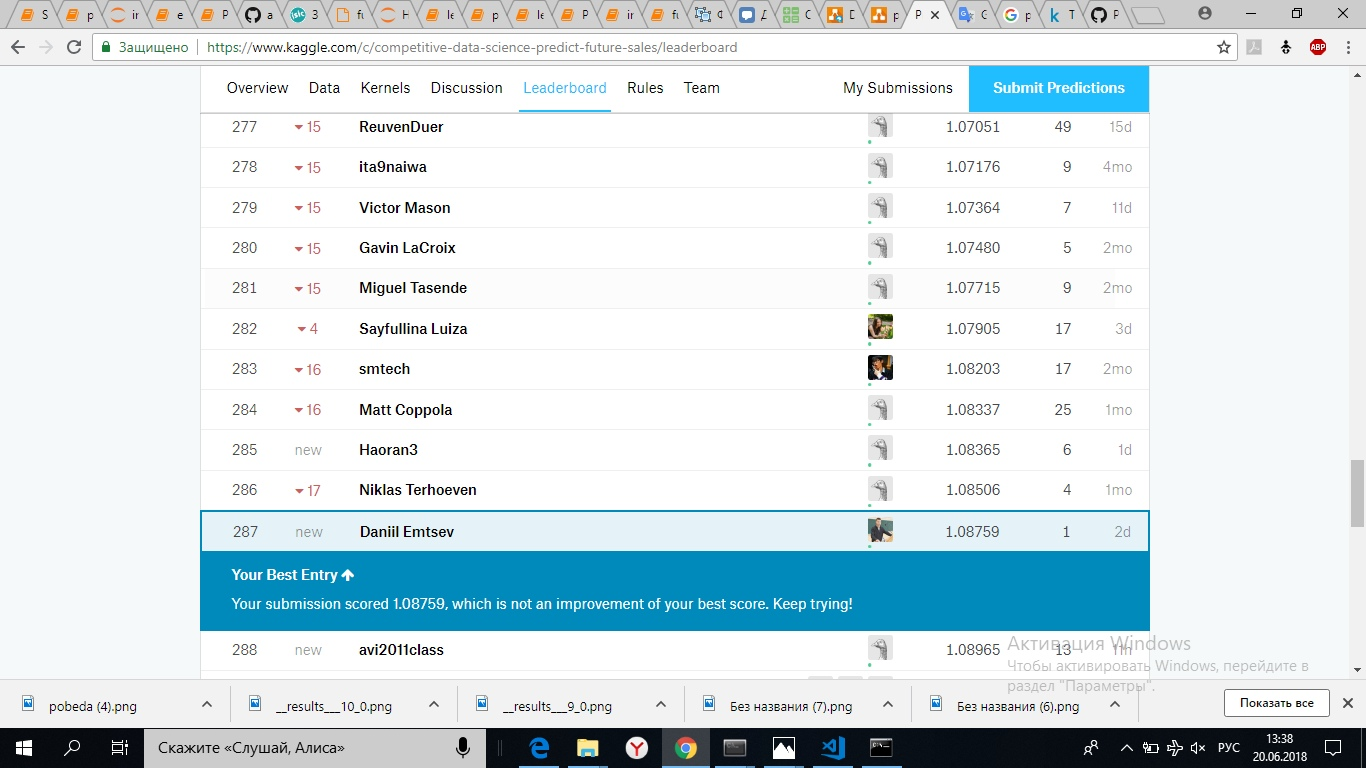

Our tricks:help coefficient 0.9 due to some facts:
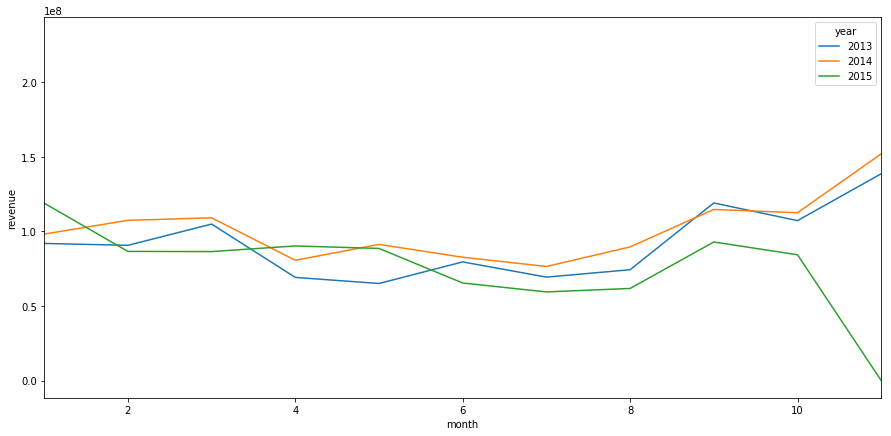

# Conclusions...

Thank you for your attention!!

# Additional classifires(not so good)

## Linearreg

In [36]:
def linearReg(X_train, y_train, X_test, y_test):
    X_train = X_train.drop(['shop_id','item_id', 'item_category_id'], axis = 1)
    X_test = X_test.drop(['shop_id','item_id', 'item_category_id'], axis = 1)
    model = linear_model.LinearRegression()
    model.fit(X_train.values, y_train)
    pred = model.predict(X_test.values)
    pred = pred.clip(0, 20)

    MSETest = mean_squared_error(y_test, pred)
    RMSETest = np.sqrt(MSETest)
    
    MSETrain = mean_squared_error(y_train, model.predict(X_train.values).clip(0, 20))
    RMSETrain = np.sqrt(MSETrain)
    
    print('Train RMSE:', RMSETrain)
    print('Test RMSE:', RMSETest)
    print('')
    print('y_test mean: ', y_test.mean())
    print('prediction mean: ', pred.mean())
    
    return model

In [21]:
ridgeResult = {}
for alpha in [0, 1e-10, 1e-5, 1e-3, 1e-2, 0.5, 1, 10]:    
    # define model
    model = linear_model.Ridge(alpha = alpha, normalize = True)
    model.fit(X_train.values, y_train)
    
    #make prediction
    pred = model.predict(X_test.values)
    pred = pred.clip(0, 20)

    # calculate score
    MSETest = mean_squared_error(y_test, pred)
    RMSETest = np.sqrt(MSETest)
    MSETrain = mean_squared_error(y_train, model.predict(X_train.values))
    RMSETrain = np.sqrt(MSETrain)
    
    # save results
    ridgeResult[alpha] = RMSETest
    
    st = datetime.datetime.fromtimestamp(time.time()).strftime('%m%d_%H.%M')
    joblib.dump(model, 'ridge_' + str(alpha) + '_' + st + '.pkl')
    
    print('ridge_' + str(alpha) + '_' + st + '.pkl')
    print('Alpha:', alpha, 'Train RMSE:', RMSETrain, 'Test RMSE:', RMSETest)
    

ridge_0_0201_15.06.pkl
Alpha: 0 Train RMSE: 0.90642697 Test RMSE: 1.1543889
ridge_1e-10_0201_15.06.pkl
Alpha: 1e-10 Train RMSE: 0.9063489 Test RMSE: 1.3144988
ridge_1e-05_0201_15.07.pkl
Alpha: 1e-05 Train RMSE: 0.90634835 Test RMSE: 1.1547109
ridge_0.001_0201_15.07.pkl
Alpha: 0.001 Train RMSE: 0.9063636 Test RMSE: 1.1545651
ridge_0.01_0201_15.07.pkl
Alpha: 0.01 Train RMSE: 0.9065299 Test RMSE: 1.1544814
ridge_0.5_0201_15.07.pkl
Alpha: 0.5 Train RMSE: 0.92709523 Test RMSE: 1.1845108
ridge_1_0201_15.07.pkl
Alpha: 1 Train RMSE: 0.94325536 Test RMSE: 1.2006776
ridge_10_0201_15.07.pkl
Alpha: 10 Train RMSE: 1.0806948 Test RMSE: 1.3050978


## LightGbm

In [ ]:
def lgb_model(params):
    lgb_model = lgb.train(params, train_data, valid_sets=[train_data, test_data], verbose_eval=25)
    return lgb_model

In [ ]:
params = {
    'application':'regression',
    'learning_rate':0.001,
    'early_stopping_round':10,
    'metric':'l2_root', #RMSE
    'nthread':-1, 
    'train_metric': True,
    'num_boost_round': 1000,
    'max_depth:': 2
}

In [ ]:
train_data = lgb.Dataset(X_train_meta, label= y_train_meta)
test_data = lgb.Dataset(X_test_meta, label = y_test_meta)

In [ ]:
model = lgb_model(params) 